# Deep Hedging AI
### Vanilla Deep Hedging engine reference implementation with dynamic training update.


In [1]:
import sys
sys.path.append('C:\source\deep_hedging\hansbuehler_deephedging')

In [2]:
"""
When working on the code base, activate below code:

import imp
import deephedging.base as base
imp.reload(base)
import deephedging.world as world
imp.reload(world)
import deephedging.agents as agents
imp.reload(agents)
import deephedging.objectives as objectives
imp.reload(objectives)
import deephedging.gym as gym
imp.reload(gym)
import deephedging.trainer as trainer
imp.reload(trainer)
"""

print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from trainer import train
from gym import VanillaDeepHedgingGym
from world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
nSamples = 20000
nSteps = 20
config.world.black_scholes = True
config.world.samples = nSamples
config.world.steps = nSteps
config.world.rvol= 0.2
config.world.dt = 1.0/12.0
config.world.drift = 0.0  # Mean drift of the asset; default: 0.1
config.world.strike = 0.0  # Relative strike. Set to zero to turn off option; default: 1.0
config.world.cost_p = 1  # Trading cost for the option on top of delta and vega cost; default: 0.0005
config.world.cost_s = 0.1/1000000  # Trading cost spot; default: 0.0002
config.world.cost_v = 1  # Trading cost vega; default: 0.02
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.width = 40
config.gym.agent.network.activation = "relu"
# trainer
config.trainer.train.batch_size = None
config.trainer.train.optimizer = "Adam"
config.trainer.train.learing_rate = 0.0001
config.trainer.train.batch_size = 256
config.trainer.train.epochs = 200
config.trainer.train.run_eagerly = False
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
sim_spot = world.spot

Deep Hedging AI says hello  ... Tensorflow version 2.11.0


## Deep Hedging in Black \& Scholes World

Deep Hedging Engine: first of 200 epochs for 20000 samples (1000 validation samples) started. Compiling graph ...       


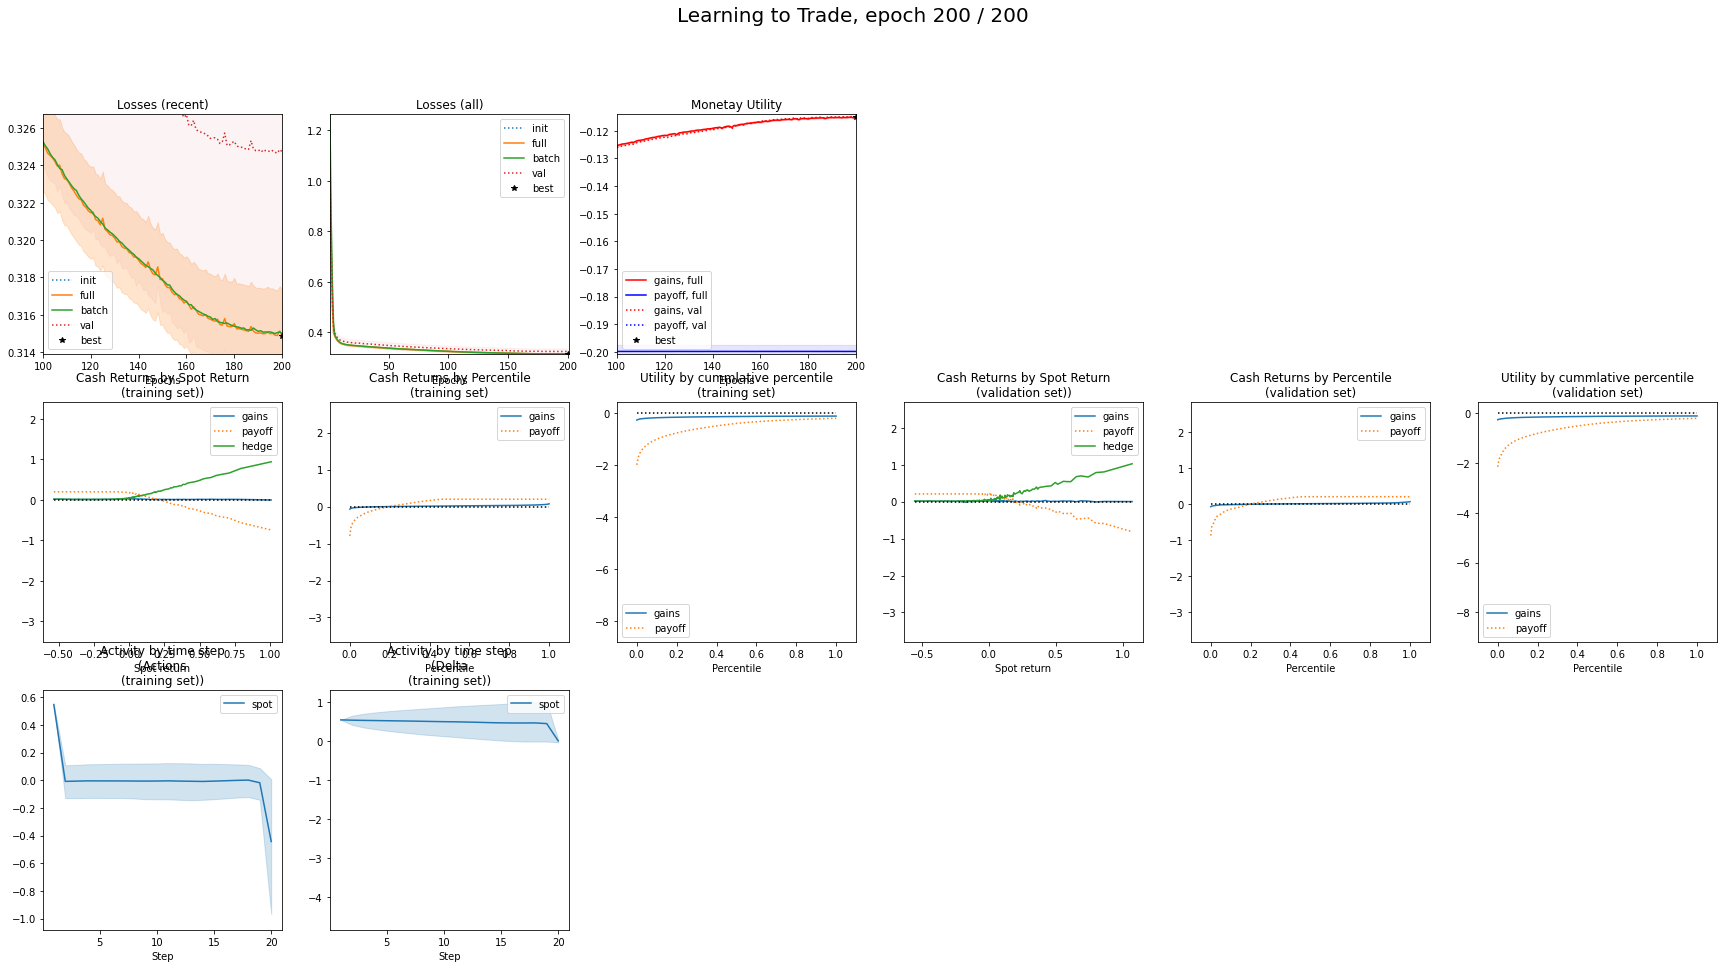

Training 200/200 epochs; 20000 samples; 1000 validation samples batch size 256 | initial loss 1.58521 (0.0188701), full 0.314891 (0.00241517), best 0.314891 (0.0188701), batch 0.315009, val 0.324725 (0.0115723). Best epoch 199 | time elapsed 10:36; estimated time remaining 3s                          
 Status: Ran all 200 epochs

Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions', 'deltas'])
Config usage report
config.gym.agent.network['activation'] = relu # Network activation function; default: relu
config.gym.agent.network['depth'] = 3 # Network depth; default: 3
config.gym.agent.network['width'] = 40 # Network width; default: 20
config.gym.agent['agent_type'] = feed_forward # Which network agent type to use; default: feed_forward
config.gym.agent['features'] = ['price', 'delta', 'time_left'] # Named features the agent uses from the environment; default: ['price', 'delta', 'time_left']
config.gym.environ

In [3]:

sim_delta = world.model_delta
val_world  = world.clone(samples=1000)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()


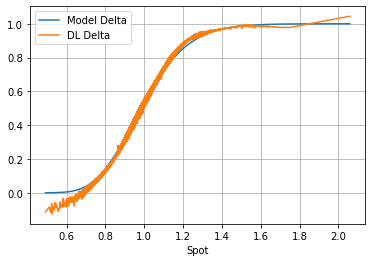

In [12]:
import pandas as pd
idx = 9
df = pd.DataFrame( index = range(0,nSamples))
df['Spot'] = sim_spot[:,idx]
df['Model Delta'] = sim_delta[:,idx]
df['DL Delta'] = r['deltas'].numpy()[:,idx,0]
df.groupby('Spot')[['Model Delta','DL Delta']].mean().sort_index().plot(grid = True)

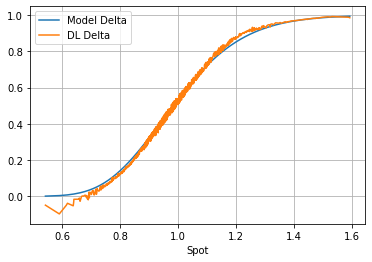

In [13]:
df = pd.DataFrame( index = range(0,1000))
df['Spot'] = val_world.spot[:,idx]
df['Model Delta'] = val_world.model_delta[:,idx]
rt = gym(val_world.tf_data)
df['DL Delta'] = rt['deltas'].numpy()[:,idx,0]
df.groupby('Spot')[['Model Delta','DL Delta']].mean().sort_index().plot(grid = True)